In [21]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.cluster import  estimate_bandwidth

In [2]:
# Funktioniert nicht
def mz(img):    
    # quantize image with 10x10 blocks
    h, w, c = img.shape

    hs = round(h/10)
    ws = round(w/10)

    resized_img = cv.resize(img, (hs,ws), interpolation=cv.INTER_AREA)
    resized_np = np.array(resized_img, dtype="float32")
    img_luv = cv.cvtColor(resized_img, cv.COLOR_BGR2LUV)
    img_luv_np = np.array(img_luv, dtype="float32")
    res = np.zeros((hs,ws), dtype="float32")
    # gaussian distance from perception unit color to color in LUV spac

    for col in range(ws-1):
        for row in range(hs-1):
            r1, g1, b1 = resized_np[col, row]
            r2, g2, b2 = img_luv_np[col, row]
            tmp = (r1-r2)**2 + (g1-g2)**2 + (b1-b2)**2
            eucl_distance = math.sqrt(tmp)
            #print(resized_img[row, col])
            res[row, col] = eucl_distance
            #print(img_luv[row, col])
    res_normalized = cv.cvtColor(res, cv.COLOR_BGR2RGB)


    cv.imshow("Resized img", res_normalized)
    cv.waitKey(0)


In [64]:
# Mean shift clustering 
def mean_shift(X):
    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
    msc = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    msc.fit(X)
    cluster_centers = msc.cluster_centers_
    labels = msc.labels_
    cluster_label = np.unique(labels)
    n_clusters = len(cluster_label)
    print("Anzahl Cluster: ", n_clusters)
    return labels

In [67]:
# https://ieeexplore.ieee.org/document/5206596
# Details in Readme: 3.1 Saliency Detection > Frequency tuned saliency detection
def dog_saliency(img):
    # Convert to Lab color space, where perceived distance corresponds to euklidean distance
    lab_img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sigma_l = cv.GaussianBlur(lab_img, (3,3), 0)
    sigma_h = cv.GaussianBlur(lab_img, (5,5), 0)
    # Calculate Difference of Gaussian
    dog = sigma_l - sigma_h
    saliency_map = np.zeros(gray_img.shape, dtype="float32")
    img_mean = np.average(gray_img)
    img_mean_b = np.average(img[:,:,0])
    img_mean_g = np.average(img[:,:,1])
    img_mean_r = np.average(img[:,:,2])

    # Mean pixel values of corresponding channels of Lab image
    img_mean_l = np.average(lab_img[:,:,0])
    img_mean_a = np.average(lab_img[:,:,1])
    img_mean_b2 = np.average(lab_img[:,:,2])
    

    # Compute Saliency: S(x,y) = I_mu - I_sigmah(x,y)
    for row in range(dog.shape[0]):
        for col in range(dog.shape[1]):
            saliency_val = np.abs(img_mean - dog[row, col])
            #saliency_val = math.sqrt((img_mean_b - dog[row, col, 0])**2 + (img_mean_g - dog[row, col, 1])**2 + (img_mean_r - dog[row, col, 2])**2)

            # Saliency using LAB color space and L2 norm
            saliency_val = math.sqrt((img_mean_l - dog[row, col, 0])**2 + (img_mean_a - dog[row, col, 1])**2 + (img_mean_b2 - dog[row, col, 2])**2)
            #print(saliency_val)
            saliency_map[row, col] = saliency_val
    sal_normalized = cv.normalize(saliency_map, None,0,1,norm_type=cv.NORM_MINMAX,dtype=cv.CV_32F)
    sal_rgb = cv.cvtColor(sal_normalized, cv.COLOR_BGR2RGB)

    # Do Mean Shift clustering also in Lab
    flatImg=np.reshape(sal_normalized, [-1, 1])
    labels = mean_shift(flatImg)

    segmentedImg = np.reshape(labels, sal_normalized.shape[:2])
    #segmentedImg_rgb = cv.cvtColor(segmentedImg, cv.COLOR_BGR2RGB)
    print(segmentedImg.shape)

    plt.imshow(segmentedImg)
    plt.show()

In [4]:
# Based on paper: https://www.sciencedirect.com/science/article/abs/pii/S0262885609001371
def static_spectral_saliency(img):
    # https://github.com/ivanred6/image_saliency_opencv
    saliency = cv.saliency.StaticSaliencySpectralResidual_create()
    (success, saliencyMap) = saliency.computeSaliency(img)
    saliencyMap = (saliencyMap * 255).astype("uint8")
    fig, arr = plt.subplots(1,2, figsize=(20,20))
    arr[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    arr[1].imshow(cv.cvtColor(saliencyMap, cv.COLOR_BGR2RGB))
    plt.show()

In [5]:
# Based on paper: https://ieeexplore.ieee.org/document/4270292
def static_fine_saliency(img):
    saliency = cv.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap) = saliency.computeSaliency(img)
    threshMap = cv.threshold(saliencyMap.astype("uint8"), 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    fig, arr = plt.subplots(1,3, figsize=(20,20))
    arr[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    arr[1].imshow(cv.cvtColor(saliencyMap, cv.COLOR_BGR2RGB))
    arr[2].imshow(cv.cvtColor(threshMap, cv.COLOR_BGR2RGB))
    plt.show()

In [6]:
def object_saliency(img):
    saliency = cv.saliency.ObjectnessBING_create()
    modelpath = "/Users/deborahhoeltje/Documents/WS2122_G06/opencv_contrib/modules/saliency/samples/ObjectnessTrainedModel"
    saliency.setTrainingPath(modelpath)
    # compute the bounding box predictions used to indicate saliency
    (success, saliencyMap) = saliency.computeSaliency(img)
    numDetections = saliencyMap.shape[0]

    # loop over the detections
    for i in range(0, min(numDetections, 10)):
        # extract the bounding box coordinates
        (startX, startY, endX, endY) = saliencyMap[i].flatten()
        
        # randomly generate a color for the object and draw it on the image
        output = img.copy()
        color = np.random.randint(0, 255, size=(3,))
        color = [int(c) for c in color]
        cv.rectangle(output, (startX, startY), (endX, endY), color, 2)
        # show the output image
        cv.imshow("Image", output)
        cv.waitKey(0)

In [74]:
img = cv.imread("../resources/tiger.jpg")

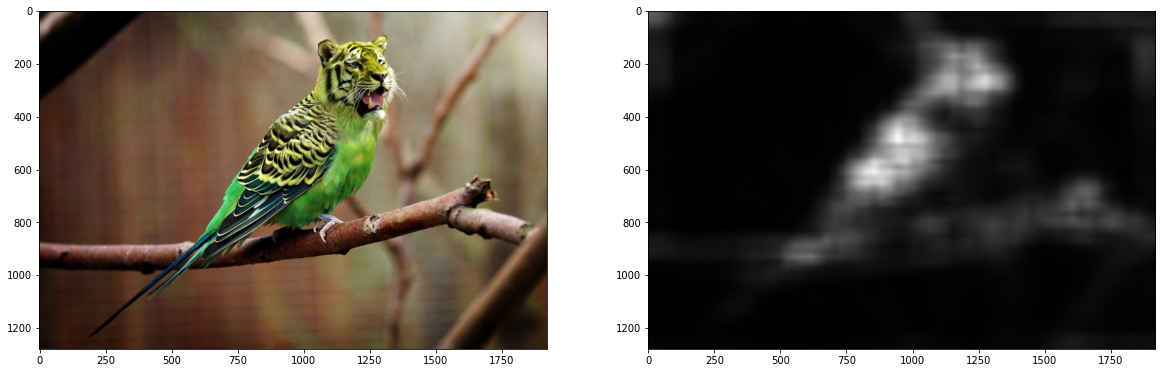

In [7]:
static_spectral_saliency(img)

7
(1279, 1920)


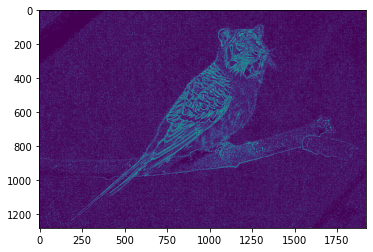

In [75]:
dog_saliency(img)

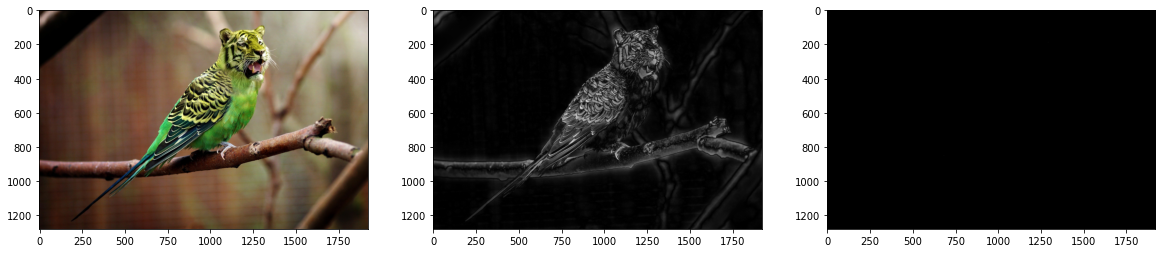

In [8]:
static_fine_saliency(img)